general linear models are linear regressions
```
y = ax + b
```

generalized linear models include logistic regression
```
g(y) = ax + b
where g is called the link function, eg logit g(p) = ln(p/(1-p)) for binary y, or log for count y
```

# Part 1: Schezophrenia and smoking

This is an [example](http://psych.colorado.edu/~carey/qmin/qminChapters/QMIN09-GLMIntro.pdf)
from Gregory Carey from UC Boulder.

We know that schizophrenics smoke a lot. Following up, we wonder:
- Do schizophrenics have more or fewer nicotinic receptors [nAChRs](https://en.wikipedia.org/wiki/Nicotinic_acetylcholine_receptor) in their brain?
- We measure receptor density from autopsies. The density may vary with age, and schizophrenia may impact lifespan. 
If schizophrenics have different nAChRs, is it simply related to them dying earlier/later?
- We rarely know smoking status at death, but can use [cotinine](https://en.wikipedia.org/wiki/Cotinine) 
as proxy for nicotine intake. 
If schizophrenics have different nAChRs, is it simply related to them smoking more?


In [10]:
import pandas as pd
from io import StringIO

# data from Gregory Carey, UC Boulder 
# http://psych.colorado.edu/~carey/qmin/qminChapters/QMIN09-GLMIntro.pdf
s = """
schizo,schizo_bool,age,smoke,cotinine,nachr
1,No,0,55,No,2.00,18.53
2,No,0,83,No,9.03,11.73
3,No,0,52,,5.6,19.01
4,No,0,74,No,2.00,25.93
5,No,0,61,No,2.00,21.66
6,No,0,56,,103.11,25.54
7,No,0,80,,5.27,11.28
8,No,0,84,,4.85,16.22
9,No,0,49,Yes,85.19,30.69
10,No,0,87,Yes,78.54,21.03
11,No,0,74,,72.33,23.65
12,No,0,44,,4.40,17.27
13,No,0,94,No,2.00,17.34
14,Yes,1,91,,4.69,11.41
15,Yes,1,70,,100.70,10.90
16,Yes,1,58,,65.50,21.38
17,Yes,1,61,,78.89,12.45
18,Yes,1,42,Yes,84.64,27.20
19,Yes,1,70,,66.74,17.08
20,Yes,1,69,,108.62,26.77
21,Yes,1,30,,74.00,19.56
22,Yes,1,70,Yes,90.08,17.73
23,Yes,1,40,Yes,113.77,26.30
24,Yes,1,91,No,2.00,10.30
"""
df = pd.read_csv(StringIO(s))
df.head()

,Schizophrenia,SzDummyCode,Age,Smoke,Cotinine,nAChR
1,No,0,55,No,2.00,18.53
2,No,0,83,No,9.03,11.73
3,No,0,52,NaN,5.60,19.01
4,No,0,74,No,2.00,25.93
5,No,0,61,No,2.00,21.66


# Part 2: star 98 dataset

Using the Star98 dataset from `Jeff Gill (2000) Generalized linear models: A unified approach`. 

[Source code](https://www.statsmodels.org/dev/examples/notebooks/generated/glm.html#GLM:-Binomial-response-data)

Data
- Around 300 California counties.
- 2 outcomes: number of students above/below national median test score.
- a dozen predictors, like county's proportion of low-income students or proportion of minority teachers.

The general idea is to regress the 2 counts, as a binomial outcome, against the dozen predictors.
A naive linear regression isn't adequate because the outcome isn't gaussian.
So we use a binomial link.


In [1]:
%matplotlib inline
import numpy as np
import statsmodels.api as sm
from scipy import stats
from matplotlib import pyplot as plt

"""
some good resources
- gentle intro to glm http://psych.colorado.edu/~carey/qmin/qminChapters/QMIN09-GLMIntro.pdf
- anova vs ancova https://psych.unl.edu/psycrs/942/q3/ancova_142.pdf
- general vs generalized linear models vs GAM  https://www.quora.com/What-is-the-difference-between-general-linear-models-and-generalized-linear-models
https://learnerworld.tumblr.com/post/152330635640/enjoystatisticswithme
gist of it is: general is lin reg, generalized is log reg (eg predict a yes/no).
- Jeff Gill 2000 https://www.amazon.com/Generalized-Linear-Models-Quantitative-Applications-ebook-dp-B07VMYLJQR/dp/B07VMYLJQR/ref=mt_kindle?_encoding=UTF8&me=&qid=#reader_B07VMYLJQR
- 

"""
print(sm.datasets.star98.NOTE) # codebook

::

    Number of Observations - 303 (counties in California).

    Number of Variables - 13 and 8 interaction terms.

    Definition of variables names::

        NABOVE   - Total number of students above the national median for the
                   math section.
        NBELOW   - Total number of students below the national median for the
                   math section.
        LOWINC   - Percentage of low income students
        PERASIAN - Percentage of Asian student
        PERBLACK - Percentage of black students
        PERHISP  - Percentage of Hispanic students
        PERMINTE - Percentage of minority teachers
        AVYRSEXP - Sum of teachers' years in educational service divided by the
                number of teachers.
        AVSALK   - Total salary budget including benefits divided by the number
                   of full-time teachers (in thousands)
        PERSPENK - Per-pupil spending (in thousands)
        PTRATIO  - Pupil-teacher ratio.
        PCTAF    - Percenta

In [2]:
def prep_star_data(add_intercept = True):
    """ return tuple: 
    pandas dataframe, 
    list of outcome column names, 
    list of predictor column names
    
    Note: this returns 2 y columns, because binomial expects 
    one for success (above national median) and one for failures (below).
    """
    dataset = sm.datasets.star98.load(as_pandas=True) # Dataset with 3 df: data, endog, and exog.
    df = dataset.data
    outcome_cols = list(dataset.endog.columns)
    predictor_cols = list(dataset.exog.columns) 
    
    if add_intercept:
        df['intercept'] = 1
        predictor_cols += ['intercept']
        
    return df, outcome_cols, predictor_cols


df, y_cols, x_cols = prep_star_data()
print('outcomes: ', y_cols)
print('predictors: ', x_cols)
df.head()


outcomes:  ['NABOVE', 'NBELOW']
predictors:  ['LOWINC', 'PERASIAN', 'PERBLACK', 'PERHISP', 'PERMINTE', 'AVYRSEXP', 'AVSALK', 'PERSPENK', 'PTRATIO', 'PCTAF', 'PCTCHRT', 'PCTYRRND', 'PERMINTE_AVYRSEXP', 'PERMINTE_AVSAL', 'AVYRSEXP_AVSAL', 'PERSPEN_PTRATIO', 'PERSPEN_PCTAF', 'PTRATIO_PCTAF', 'PERMINTE_AVYRSEXP_AVSAL', 'PERSPEN_PTRATIO_PCTAF', 'intercept']


,NABOVE,NBELOW,LOWINC,PERASIAN,PERBLACK,PERHISP,PERMINTE,AVYRSEXP,AVSALK,PERSPENK,...,PCTYRRND,PERMINTE_AVYRSEXP,PERMINTE_AVSAL,AVYRSEXP_AVSAL,PERSPEN_PTRATIO,PERSPEN_PCTAF,PTRATIO_PCTAF,PERMINTE_AVYRSEXP_AVSAL,PERSPEN_PTRATIO_PCTAF,intercept
0,452.0,355.0,34.39730,23.299300,14.235280,11.411120,15.91837,14.70646,59.15732,4.445207,...,22.222220,234.102872,941.68811,869.9948,96.50656,253.52242,1238.1955,13848.8985,5504.0352,1
1,144.0,40.0,17.36507,29.328380,8.234897,9.314884,13.63636,16.08324,59.50397,5.267598,...,0.000000,219.316851,811.41756,957.0166,107.68435,340.40609,1321.0664,13050.2233,6958.8468,1
2,337.0,234.0,32.64324,9.226386,42.406310,13.543720,28.83436,14.59559,60.56992,5.482922,...,0.000000,420.854496,1746.49488,884.0537,103.92435,295.75929,1022.4252,25491.1232,5605.8777,1
3,395.0,178.0,11.90953,13.883090,3.796973,11.443110,11.11111,14.38939,58.33411,4.165093,...,7.142857,159.882095,648.15671,839.3923,90.11341,204.34375,1061.4545,9326.5797,4421.0568,1
4,8.0,57.0,36.88889,12.187500,76.875000,7.604167,43.58974,13.90568,63.15364,4.324902,...,0.000000,606.144976,2752.85075,878.1943,81.22097,226.54248,983.7059,38280.2616,4254.4314,1


In [3]:
glm_binom = sm.GLM(df[y_cols], df[x_cols], family=sm.families.Binomial())
res = glm_binom.fit()
print(res.summary())

                  Generalized Linear Model Regression Results                   
Dep. Variable:     ['NABOVE', 'NBELOW']   No. Observations:                  303
Model:                              GLM   Df Residuals:                      282
Model Family:                  Binomial   Df Model:                           20
Link Function:                    logit   Scale:                          1.0000
Method:                            IRLS   Log-Likelihood:                -2998.6
Date:                  Sun, 19 Jan 2020   Deviance:                       4078.8
Time:                          17:43:12   Pearson chi2:                 4.05e+03
No. Iterations:                       5                                         
Covariance Type:              nonrobust                                         
                              coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------------------
LOWINC

                                 OLS Regression Results                                
Dep. Variable:                 NABOVE   R-squared (uncentered):                   0.175
Model:                            OLS   Adj. R-squared (uncentered):              0.172
Method:                 Least Squares   F-statistic:                              64.08
Date:                Sun, 19 Jan 2020   Prob (F-statistic):                    2.60e-14
Time:                        17:43:12   Log-Likelihood:                         -2406.9
No. Observations:                 303   AIC:                                      4816.
Df Residuals:                     302   BIC:                                      4820.
Df Model:                           1                                                  
Covariance Type:            nonrobust                                                  
                 coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------

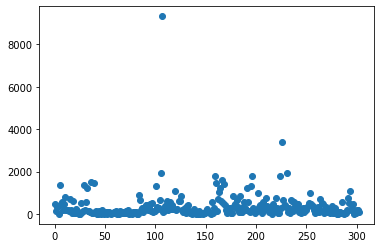

In [4]:
# linreg = sm.OLS(df[y_cols], df[x_cols[0:]])
# res = linreg.fit()
y = df[y_cols[:1]]
x = list(range(len(y)))
plt.scatter(x,y)
linreg = sm.OLS(y, x)
res = linreg.fit()
print(res.summary())